In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [2]:
import plotly
import plotly.offline as pyo
import plotly.express as px
import plotly.graph_objs as go
pyo.init_notebook_mode()

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
#https://www.kaggle.com/teocalvo/dota2-pro-players-matches-2019-202106
dataset = pd.read_csv("data/tb_pro_players_matches.csv")

## Матчи Dota проигроков
Этот набор данных далеко не сырые данные, поскольку он прошел несколько этапов преобразований, пересечений и агрегатов. Представленная информация представляет собой статистику каждой команды за день до начала рассматриваемого матча. Такая статистика рассчитывается на основе информации о матчах каждого игрока за 6 месяцев, предшествующих рассматриваемому матчу.

Таким образом, каждая строка этого набора данных содержит информацию о том, какая команда выиграла матч, а также обобщенную и «ненормализованную» статистику для каждой команды. 

In [5]:
dataset.head()

match_id             dt_match  radiant_win  recencia_r  freq_r  \
0  5796599901  2021-01-21 17:56:33        False        12.0    29.8   
1  5796710768  2021-01-21 19:46:41         True        12.0    29.8   
2  4632569639  2019-04-09 12:20:37        False         2.0    12.2   
3  5080525118  2019-10-22 10:33:05        False         2.0    11.0   
4  5176256941  2019-12-30 14:32:03         True         2.0    42.2   

   win_pct_r  duration_avg_win_r  duration_avg_lose_r  actions_per_min_avg_r  \
0   0.653419           32.096962            40.586062             316.847224   
1   0.653419           32.096962            40.586062             316.847224   
2   0.140476           30.070000            41.732857             211.074603   
3   0.181818           26.600000            27.470370             209.745455   
4   0.457456           34.083080            31.864634                    NaN   

   ancient_kills_avg_r  ...  hero_110_avg_d  hero_111_avg_d  hero_112_avg_d  \
0             6.738015  ...        0.048718        0.011538        0.000000   
1             6.738015  ...        0.048718        0.011538        0.000000   
2             5.580159  ...        0.000000        0.000000        0.000000   
3             2.836364  ...        0.000000        0.000000        0.024812   
4                  NaN  ...        0.000000        0.000000        0.015873   

   hero_113_avg_d  hero_114_avg_d  hero_119_avg_d  hero_120_avg_d  \
0             0.0        0.003846        0.000000        0.046154   
1             0.0        0.003846        0.000000        0.046154   
2             0.0        0.000000        0.066667        0.066667   
3             0.0        0.000000        0.000000        0.000000   
4             0.0        0.004878        0.038095        0.000000   

   hero_126_avg_d  hero_128_avg_d  hero_129_avg_d  
0        0.034615        0.007692        0.026923  
1        0.034615        0.007692        0.026923  
2        0.000000        0.000000        0.000000  
3        0.000000        0.000000        0.000000  
4        0.000000        0.000000        0.000000  

[5 rows x 317 columns]

In [5]:
columns = list(dataset.columns)

Я хочу удалить всю информацию о героях из набора данных, так как он занимает 238 столбцов. Обычно игроки выбирают героев, на которых они тренировались или в которых они хороши, так что это не очень важная информация. 

In [6]:
hero_avg_d = pd.DataFrame({'hero_1_avg_d' : dataset.pop('hero_1_avg_d')})
for i in range(2,130):
    name = 'hero_' + str(i) + '_avg_d'
    if (name in columns):
        hero_avg_d[name] = dataset.pop(name)
        
hero_avg_d['_win'] = dataset['radiant_win']
hero_avg_d.loc[hero_avg_d['_win'] == False, "win"] = 1
hero_avg_d['win'] = hero_avg_d['win'].fillna(0)
hero_avg_d.pop('_win')
hero_avg_d.head()

hero_1_avg_d  hero_2_avg_d  hero_3_avg_d  hero_4_avg_d  hero_5_avg_d  \
0      0.011538      0.015385      0.000000      0.011538      0.000000   
1      0.011538      0.015385      0.000000      0.011538      0.000000   
2      0.000000      0.000000      0.133333      0.000000      0.000000   
3      0.000000      0.000000      0.010526      0.000000      0.024812   
4      0.000000      0.000000      0.000000      0.000000      0.000000   

   hero_6_avg_d  hero_7_avg_d  hero_8_avg_d  hero_9_avg_d  hero_10_avg_d  ...  \
0      0.000000      0.000000      0.003846      0.007692       0.026923  ...   
1      0.000000      0.000000      0.003846      0.007692       0.026923  ...   
2      0.000000      0.000000      0.000000      0.000000       0.066667  ...   
3      0.022222      0.022222      0.000000      0.000000       0.000000  ...   
4      0.004878      0.011111      0.004878      0.014286       0.019512  ...   

   hero_111_avg_d  hero_112_avg_d  hero_113_avg_d  hero_114_avg_d  \
0        0.011538        0.000000             0.0        0.003846   
1        0.011538        0.000000             0.0        0.003846   
2        0.000000        0.000000             0.0        0.000000   
3        0.000000        0.024812             0.0        0.000000   
4        0.000000        0.015873             0.0        0.004878   

   hero_119_avg_d  hero_120_avg_d  hero_126_avg_d  hero_128_avg_d  \
0        0.000000        0.046154        0.034615        0.007692   
1        0.000000        0.046154        0.034615        0.007692   
2        0.066667        0.066667        0.000000        0.000000   
3        0.000000        0.000000        0.000000        0.000000   
4        0.038095        0.000000        0.000000        0.000000   

   hero_129_avg_d  win  
0        0.026923  1.0  
1        0.026923  0.0  
2        0.000000  1.0  
3        0.000000  1.0  
4        0.000000  0.0  

[5 rows x 119 columns]

In [7]:
hero_avg_r = pd.DataFrame({'hero_1_avg_r' : dataset.pop('hero_1_avg_r')})
for i in range(2,130):
    name = 'hero_' + str(i) + '_avg_r'
    if (name in columns):
        hero_avg_r[name] = dataset.pop(name)
        
hero_avg_r['_win'] = dataset['radiant_win']
hero_avg_r.loc[hero_avg_r['_win'] == True, "win"] = 1
hero_avg_r['win'] = hero_avg_r['win'].fillna(0)
hero_avg_r.pop('_win')
hero_avg_r.head()

hero_1_avg_r  hero_2_avg_r  hero_3_avg_r  hero_4_avg_r  hero_5_avg_r  \
0      0.000000      0.000000      0.000000      0.019512      0.000000   
1      0.000000      0.000000      0.000000      0.019512      0.000000   
2      0.000000      0.005556      0.005556      0.000000      0.000000   
3      0.000000      0.036364      0.000000      0.000000      0.018182   
4      0.003636      0.007407      0.045000      0.033266      0.020000   

   hero_6_avg_r  hero_7_avg_r  hero_8_avg_r  hero_9_avg_r  hero_10_avg_r  ...  \
0      0.018182      0.005714      0.030303      0.000000       0.006061  ...   
1      0.018182      0.005714      0.030303      0.000000       0.006061  ...   
2      0.000000      0.050000      0.000000      0.033333       0.028571  ...   
3      0.000000      0.018182      0.000000      0.036364       0.018182  ...   
4      0.007407      0.014747      0.000000      0.017143       0.000000  ...   

   hero_111_avg_r  hero_112_avg_r  hero_113_avg_r  hero_114_avg_r  \
0        0.000000        0.000000             0.0             0.0   
1        0.000000        0.000000             0.0             0.0   
2        0.033333        0.038889             0.0             0.0   
3        0.000000        0.018182             0.0             0.0   
4        0.005000        0.000000             0.0             0.0   

   hero_119_avg_r  hero_120_avg_r  hero_126_avg_r  hero_128_avg_r  \
0        0.017143        0.005714         0.03871        0.005714   
1        0.017143        0.005714         0.03871        0.005714   
2        0.022222        0.033333         0.00000        0.000000   
3        0.018182        0.018182         0.00000        0.000000   
4        0.005714        0.016758         0.00000        0.000000   

   hero_129_avg_r  win  
0        0.004878  0.0  
1        0.004878  1.0  
2        0.000000  0.0  
3        0.018182  0.0  
4        0.014815  1.0  

[5 rows x 119 columns]

In [8]:
dataset.pop('match_id')
dataset.pop('dt_match')
dataset.pop('isRadiant_avg_r')
dataset.pop('isRadiant_avg_d')

#Necronomicon was deleted from dota.
dataset.pop('necronomicon_kills_avg_r')
dataset.pop('necronomicon_kills_avg_d')

dataset.head()

radiant_win  recencia_r  freq_r  win_pct_r  duration_avg_win_r  \
0        False        12.0    29.8   0.653419           32.096962   
1         True        12.0    29.8   0.653419           32.096962   
2        False         2.0    12.2   0.140476           30.070000   
3        False         2.0    11.0   0.181818           26.600000   
4         True         2.0    42.2   0.457456           34.083080   

   duration_avg_lose_r  actions_per_min_avg_r  ancient_kills_avg_r  \
0            40.586062             316.847224             6.738015   
1            40.586062             316.847224             6.738015   
2            41.732857             211.074603             5.580159   
3            27.470370             209.745455             2.836364   
4            31.864634                    NaN                  NaN   

   assists_avg_r  buyback_count_avg_r  ...  observer_uses_avg_d  \
0      13.415620             0.467297  ...                  NaN   
1      13.415620             0.467297  ...                  NaN   
2      10.857937             0.786508  ...             1.866667   
3       9.581818             0.545455  ...             1.571278   
4       9.752624                  NaN  ...                  NaN   

   purchase_tpscroll_avg_d  roshan_kills_avg_d  sentry_kills_avg_d  \
0                      NaN                 NaN                 NaN   
1                      NaN                 NaN                 NaN   
2                 4.866667            0.000000            0.333333   
3                 7.447051            0.122222            0.757043   
4                      NaN                 NaN                 NaN   

   sentry_uses_avg_d  total_gold_avg_d  total_xp_avg_d  tower_damage_avg_d  \
0                NaN      14438.667308    18087.889423         1761.675000   
1                NaN      14438.667308    18087.889423         1761.675000   
2           1.066667       8111.400000     8148.333333          740.333333   
3           1.240602      12308.468020    14157.103342         2095.517327   
4                NaN      15914.523171    18711.935750         1913.308766   

   tower_kills_avg_d  xp_per_min_avg_d  
0                NaN        498.791346  
1                NaN        498.791346  
2           0.400000        330.733333  
3           0.901303        480.314520  
4                NaN        534.178071  

[5 rows x 75 columns]

In [80]:
count = pd.DataFrame(dataset['radiant_win'].value_counts())
fig = px.pie(count, values = 'radiant_win', names = ['Defeat','Victory'],
            color_discrete_sequence=['#D8BFD8', '#9370DB']
            )
fig.update_layout(
    font_family = 'monospace',
    title=dict(text='The ratio of victories and defeats', x=0.5,y=0.98,
               font=dict(size=20)),
    )
fig.update_traces(textposition='outside', textinfo='percent+label')
fig.show()

Проверка набора данных на предмет отсутствующих значений. Я заполню недостающие значения средним. 

In [9]:
print(list(dataset.isnull().sum()))

[0, 2819, 2819, 2819, 3782, 3392, 18630, 18630, 2819, 18630, 18630, 2819, 2819, 2865, 2819, 2819, 2819, 2819, 2819, 18630, 2819, 44228, 28459, 18630, 2819, 2819, 18630, 18630, 18630, 38687, 18630, 18630, 18630, 2819, 2819, 2819, 18630, 2819, 2845, 2845, 2845, 3806, 3475, 18609, 18609, 2845, 18609, 18609, 2845, 2845, 2882, 2845, 2845, 2845, 2845, 2845, 18609, 2845, 44219, 28256, 18609, 2845, 2845, 18609, 18609, 18609, 38556, 18609, 18609, 18609, 2845, 2845, 2845, 18609, 2845]


In [10]:
for variable in list(dataset.columns):
    mean = dataset[variable].mean()
    dataset[variable].fillna(mean, inplace=True)
print(list(dataset.isnull().sum()))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [11]:
print(list(dataset.dtypes))

[dtype('bool'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float

In [12]:
x, y = dataset.iloc[:,1:], dataset.iloc[:,0].astype(int)

In [13]:
list(dataset.columns)[1:38]

['recencia_r',
 'freq_r',
 'win_pct_r',
 'duration_avg_win_r',
 'duration_avg_lose_r',
 'actions_per_min_avg_r',
 'ancient_kills_avg_r',
 'assists_avg_r',
 'buyback_count_avg_r',
 'courier_kills_avg_r',
 'deaths_avg_r',
 'denies_avg_r',
 'firstblood_claimed_avg_r',
 'gold_avg_r',
 'gold_per_min_avg_r',
 'gold_spent_avg_r',
 'hero_damage_avg_r',
 'hero_healing_avg_r',
 'hero_kills_avg_r',
 'kda_avg_r',
 'kills_per_min_avg_r',
 'lane_efficiency_avg_r',
 'lane_kills_avg_r',
 'last_hits_avg_r',
 'level_avg_r',
 'neutral_kills_avg_r',
 'observer_kills_avg_r',
 'observer_uses_avg_r',
 'purchase_tpscroll_avg_r',
 'roshan_kills_avg_r',
 'sentry_kills_avg_r',
 'sentry_uses_avg_r',
 'total_gold_avg_r',
 'total_xp_avg_r',
 'tower_damage_avg_r',
 'tower_kills_avg_r',
 'xp_per_min_avg_r']

### Data Density

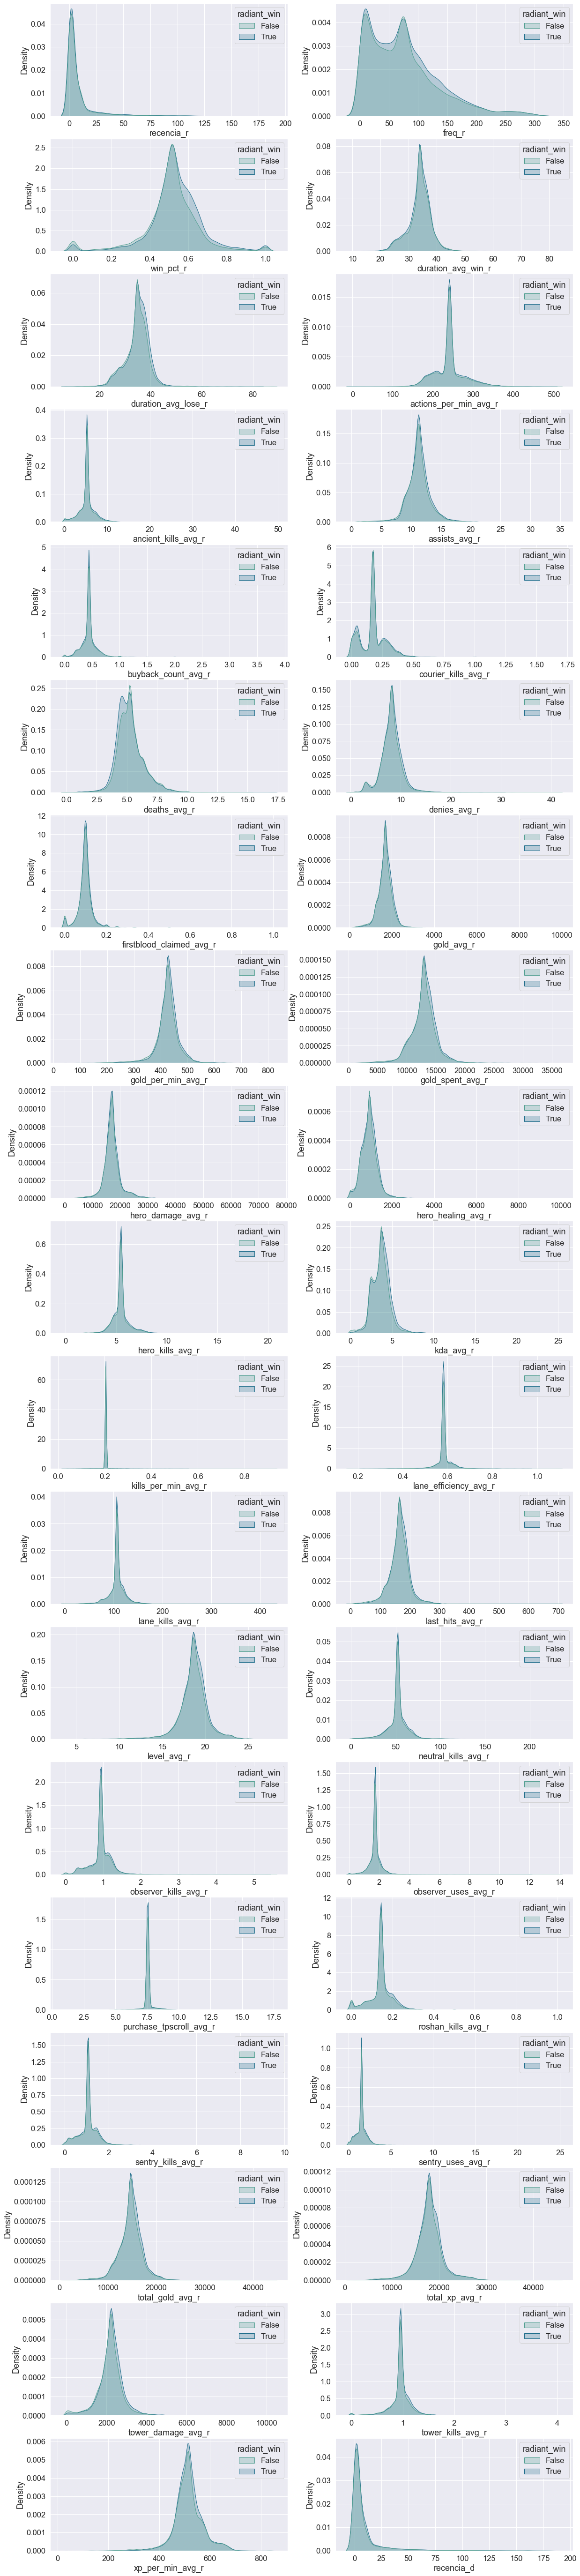

In [45]:
f, axes = plt.subplots(19, 2, figsize=(20, 100))
sns.set(font_scale=1.5)
val = 0
for i in range(19):
    for j in range(2):
        val+=1
        sns.kdeplot(data = dataset, x=list(dataset.columns)[val], hue='radiant_win', fill=True, ax=axes[i, j], palette="crest")
                

In [14]:
feature_names = list(dataset.columns)[1:38]
feature_names

['recencia_r',
 'freq_r',
 'win_pct_r',
 'duration_avg_win_r',
 'duration_avg_lose_r',
 'actions_per_min_avg_r',
 'ancient_kills_avg_r',
 'assists_avg_r',
 'buyback_count_avg_r',
 'courier_kills_avg_r',
 'deaths_avg_r',
 'denies_avg_r',
 'firstblood_claimed_avg_r',
 'gold_avg_r',
 'gold_per_min_avg_r',
 'gold_spent_avg_r',
 'hero_damage_avg_r',
 'hero_healing_avg_r',
 'hero_kills_avg_r',
 'kda_avg_r',
 'kills_per_min_avg_r',
 'lane_efficiency_avg_r',
 'lane_kills_avg_r',
 'last_hits_avg_r',
 'level_avg_r',
 'neutral_kills_avg_r',
 'observer_kills_avg_r',
 'observer_uses_avg_r',
 'purchase_tpscroll_avg_r',
 'roshan_kills_avg_r',
 'sentry_kills_avg_r',
 'sentry_uses_avg_r',
 'total_gold_avg_r',
 'total_xp_avg_r',
 'tower_damage_avg_r',
 'tower_kills_avg_r',
 'xp_per_min_avg_r']

In [15]:
#Restore the rc params from Matplotlib's internal default style
plt.rcdefaults()

## Использование нескольких методов для изучения важности критериев

In [62]:
_x, _y = dataset.iloc[:,1:38], dataset.iloc[:,0].astype(int)

In [21]:
#Использование F-statictics для определения важности критериев
from sklearn.feature_selection import f_classif
f, pval = f_classif(_x, _y)
print(pval)

[3.71514489e-04 2.22344821e-04 1.04314653e-91 1.21754936e-06
 7.27114147e-48 8.50481380e-03 8.21974838e-13 3.34338837e-30
 2.30841642e-01 1.44872009e-01 4.96858888e-47 7.68139246e-22
 5.37226914e-11 1.17886829e-25 9.40583594e-59 1.46047133e-35
 3.20230956e-10 2.18103042e-17 9.85827683e-22 1.34739155e-72
 2.85421551e-10 1.05269718e-21 1.98475242e-13 7.37772957e-20
 6.15302882e-20 1.69508761e-08 1.32681246e-04 6.70940298e-02
 3.16084737e-04 6.56283837e-22 8.09505610e-05 1.23977435e-01
 1.80653233e-30 2.58319811e-14 1.28888460e-49 7.97815425e-33
 4.81134897e-15]


Text(0.5, 1.0, 'Univariate score ($-Log(p_{value})$)')

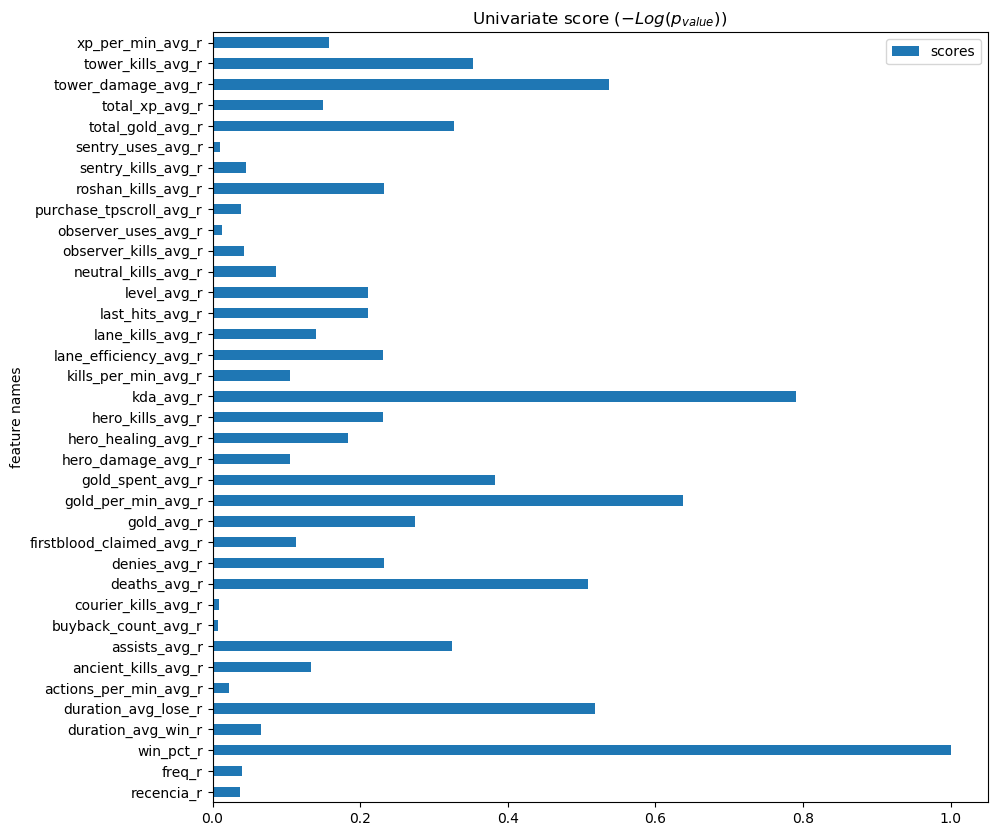

In [23]:
#https://scikit-learn.org/stable/auto_examples/feature_selection/plot_feature_selection.html#sphx-glr-auto-examples-feature-selection-plot-feature-selection-py
scores = -np.log10(pval)
scores /= scores.max()
univariate_score = pd.DataFrame({'feature names':feature_names, 'scores':scores})
univariate_score.plot.barh(x='feature names', y='scores', figsize=(10, 10))
plt.title(r'Univariate score ($-Log(p_{value})$)')

Text(0.5, 1.0, 'RandomForestClassifier feature importances')

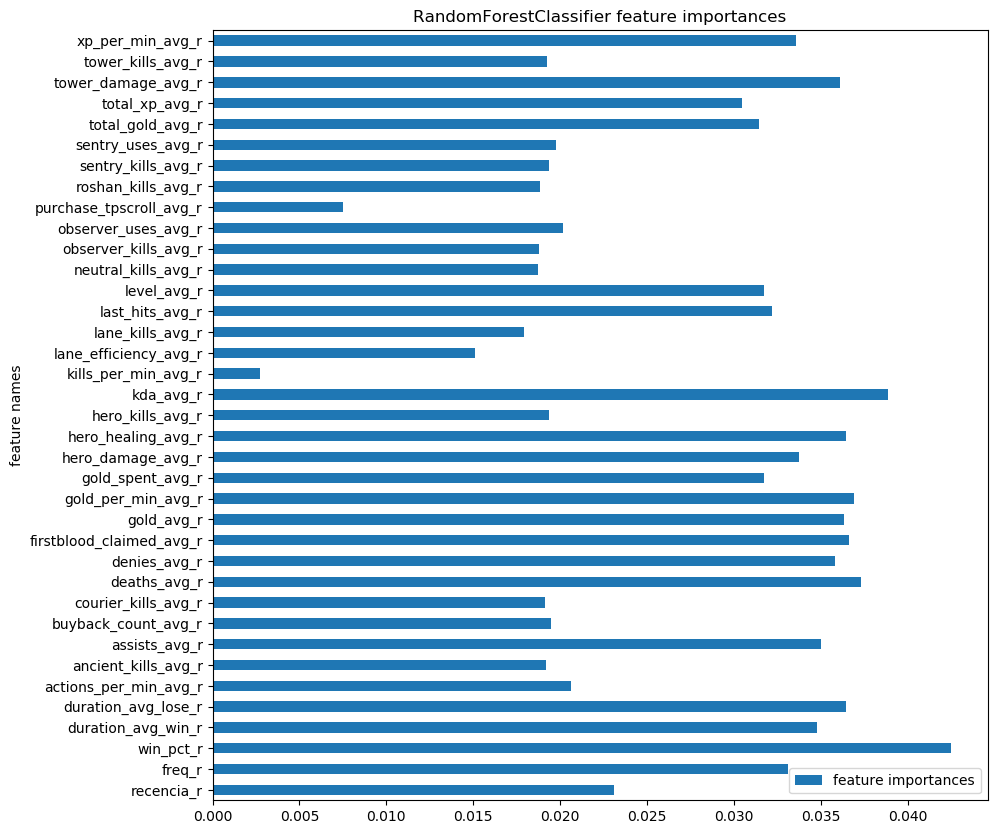

In [24]:
#Использование Random Forest(по книге) для определения важности критериев
#Это лучше для данной цели, чем boosted models, так как последние игнорируют некоторые переменные полностью
forest = RandomForestClassifier()
forest.fit(_x, _y)
df_to_plot = pd.DataFrame({'feature names':feature_names, 'feature importances':forest.feature_importances_})
df_to_plot.plot.barh(x='feature names', y='feature importances', figsize=(10, 10))
plt.title('RandomForestClassifier feature importances')

Text(0.5, 1.0, 'GradientBoostingClassifier feature importances')

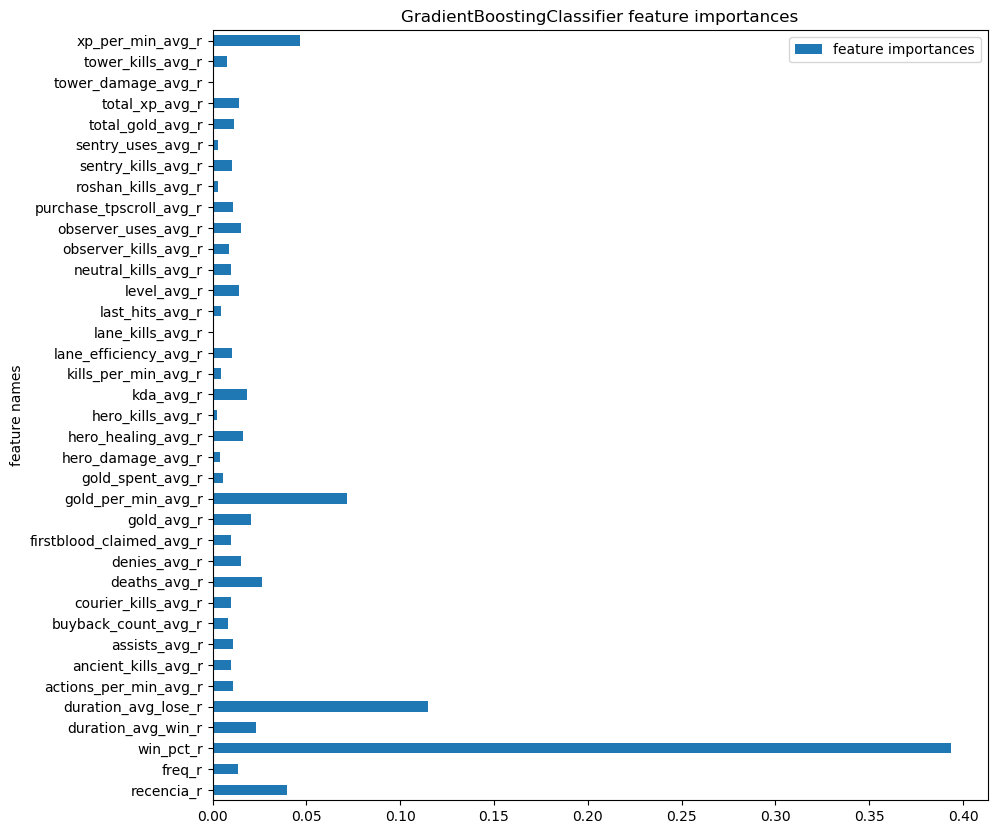

In [25]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf.fit(_x, _y)
df_to_plot = pd.DataFrame({'feature names':feature_names, 'feature importances':clf.feature_importances_})
df_to_plot.plot.barh(x='feature names', y='feature importances', figsize=(10, 10))
plt.title('GradientBoostingClassifier feature importances')

In [27]:
univariate_score.loc[univariate_score['scores'] > 0.5]

feature names    scores
2             win_pct_r  1.000000
4   duration_avg_lose_r  0.518109
10         deaths_avg_r  0.508935
14   gold_per_min_avg_r  0.637784
19            kda_avg_r  0.789945
34   tower_damage_avg_r  0.537359

## Обучение и предсказание

In [29]:
mean_importances.loc[mean_importances['feature importances'] > 0.2]

feature names  feature importances
2             win_pct_r             0.408997
4   duration_avg_lose_r             0.239717
14   gold_per_min_avg_r             0.220192
19            kda_avg_r             0.203389

In [14]:
scaler = RobustScaler().fit(x)
x_scaled = scaler.transform(x)
X_train, X_test, y_train, y_test = train_test_split(x_scaled, y, random_state=5)

In [15]:
def show_results(estimator, X_train, X_test, y_train, y_test, dataset_scaled, y):
    estimatorScores = cross_val_score(estimator, dataset_scaled, y)
    print("\nРезультат перекрестной проверки: {}".format(estimatorScores))
    print("Средняя правильность перекрестной проверки: {:.3f}".format(estimatorScores.mean()))

    estimator.fit(X_train, y_train)
    estimator_pred = estimator.predict(X_test)
    print('\nMAE: {:.4f}'.format(mean_absolute_error(y_test, estimator_pred)))
    print('RMSE: {:.4f}'.format(np.sqrt(mean_squared_error(y_test, estimator_pred))))   
    print('R2 {:.4f}'.format(r2_score(y_test, estimator_pred)))
    return estimator

In [17]:
feature_names = list(dataset.columns)[1:]

### LogisticRegression

L1 type of regularization can lead to zero coefficients i.e. some of the features are completely neglected for the evaluation of output. So Lasso regression not only helps in reducing over-fitting but it can help us in feature selection.

LogisticRegression L1

Результат перекрестной проверки: [0.58091198 0.58282078 0.57709438 0.5961824  0.57974549]
Средняя правильность перекрестной проверки: 0.583

MAE: 0.4169
RMSE: 0.6457
R2 -0.6710


Text(0.5, 1.0, 'LogisticRegression L1')

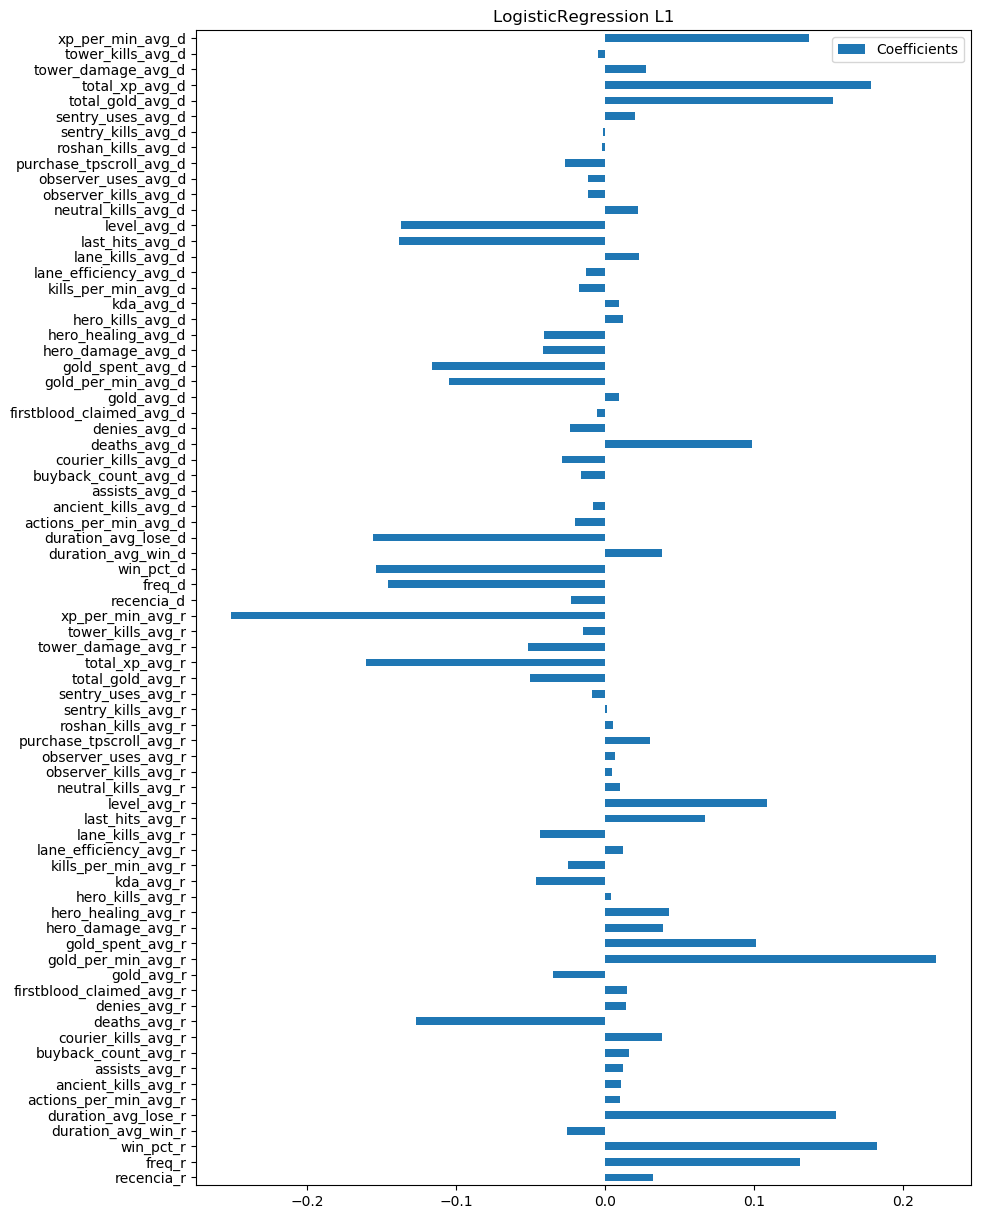

In [88]:
print("LogisticRegression L1")
log_l1 = show_results(LogisticRegression(penalty="l1", solver='saga'), X_train, X_test, y_train, y_test, x_scaled, y)
coefs_l1 = pd.DataFrame(
    log_l1.coef_.reshape(74,1),
    columns=['Coefficients'], index=feature_names
)
coefs_l1.plot(kind='barh', figsize=(10, 15))
plt.title('LogisticRegression L1')

### Naive Bayes

In [20]:
print('GaussianNB')
GNB = show_results(GaussianNB(), X_train, X_test, y_train, y_test, x_scaled, y)

GaussianNB

Результат перекрестной проверки: [0.54326617 0.55408271 0.54676564 0.54411453 0.54782609]
Средняя правильность перекрестной проверки: 0.547

MAE: 0.4615
RMSE: 0.6793
R2 -0.8499


In [21]:
print('BernoulliNB')
BNB = show_results(BernoulliNB(), X_train, X_test, y_train, y_test, x_scaled, y)

BernoulliNB

Результат перекрестной проверки: [0.56458112 0.56521739 0.56797455 0.56945917 0.56850477]
Средняя правильность перекрестной проверки: 0.567

MAE: 0.4365
RMSE: 0.6607
R2 -0.7499


### Ensemble Classifiers

In [22]:
print('AdaBoostClassifier')
ABC = show_results(AdaBoostClassifier(n_estimators=100, random_state=0), X_train, X_test, y_train, y_test, x_scaled, y)

AdaBoostClassifier

Результат перекрестной проверки: [0.58865323 0.58282078 0.58080594 0.59130435 0.58388123]
Средняя правильность перекрестной проверки: 0.585

MAE: 0.4195
RMSE: 0.6477
R2 -0.6816


In [23]:
print('GradientBoostingClassifier')
grad_boost = show_results(GradientBoostingClassifier(), X_train, X_test, y_train, y_test, x_scaled, y)

GradientBoostingClassifier

Результат перекрестной проверки: [0.60074231 0.59278897 0.58981972 0.60106045 0.59225875]
Средняя правильность перекрестной проверки: 0.595

MAE: 0.4035
RMSE: 0.6353
R2 -0.6177


In [25]:
print('RandomForestClassifier')
RFC = show_results(RandomForestClassifier(max_depth=2, random_state=0), X_train, X_test, y_train, y_test, x_scaled, y)

RandomForestClassifier

Результат перекрестной проверки: [0.56723224 0.56723224 0.56489926 0.57391304 0.57009544]
Средняя правильность перекрестной проверки: 0.569

MAE: 0.4343
RMSE: 0.6590
R2 -0.7408


## Вывод

На графике плотности для каждого критерия можно было увидеть, что почти все критерии имеют одинаковые графики для побед и поражений.

В ходе анализа важности критериев команды Radiant было выделено 6 наиболее важных, возможно влияющий критерия:
 - win_pct_r - средний процент побед игроков из команды Radiant;
 - kda_avg_r - cредний kills-deaths-assists среди игроков команды Radiant; 
 - gold_per_min_avg_r - среднее значение золота в секунду команды Radiant; 
 - tower_damage_avg_r - среднее значение урона по башням Radiant;
 - duration_avg_lose_r - среднее время выигранных матчей игроков команды Radiant;
 - deaths_avg_r - среднее количество убийств среди игроков команды Radiant.
 
Ни один из использованных методов из библиотеки sklearn не смог предсказать результат лучше, чем простое угадывание. Исходя из этого можно сделать вывод, что использованные в ходе обучения критерии не имеют влияние на победу или поражение. Конечно, выделенные выше 6 критериев могут быть использованы как способ оценить мастерство игры команды (влияющий, несомненно, на победу). 
